In [3]:
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

## Use USPTO-2M dataset

In [4]:
df = pd.read_csv('../USPTO-2M/uspto_2m.tsv', sep='\t')

In [5]:
df.head()

,Subclass_labels,Abstract,Title,No
0,"'G05B', 'H01L'",an apparatus for generating a saddle shaped tr...,saddle shaped trajectory generator for two int...,US08536817
1,'A61M',the present invention provides apparatus and m...,balloon insertion apparatus and method of seal...,US08382794
2,'A01K',a restraint system for an animal comprising a ...,retractable leash and restraint assembly,US08474414
3,"'B29C', 'B65D'",a container or tray having various features th...,container having a rim or other feature encaps...,US08540111
4,'A61K',the present invention relates to a process for...,process for the preparation or purification of...,US08592474


In [ ]:
#only keep digital patent numbers
#df['No'] = df['No'].map(lambda x: x[3:])

In [6]:
df = df.dropna().reset_index(drop=True)
len(df)

1998372

In [7]:
df.columns

Index(['Subclass_labels', 'Abstract', 'Title', 'No'], dtype='object')

In [8]:
abst_list = list(df['Abstract'])
title_list = list(df['Title'])
all_contents = abst_list + title_list

In [9]:
len(all_contents)

3996744

In [10]:
all_contents[0:2]

['an apparatus for generating a saddle shaped trajectory for intersection of two cylindrical conduits the apparatus includes an encoder module a motorized axial module connected with the encoder module and movable only in a direction parallel to a longitudinal axis of an intersecting cylindrical conduit and a motorized rotatable module connected with the motorized axial module and rotatable around the longitudinal axis of the intersecting cylindrical conduit control software provided in one of the modules includes an algorithm providing control of the modules for generation of the saddle shaped trajectory on the two cylindrical conduits the algorithm requires input of only a radius of each of the cylindrical conduits',
 'the present invention provides apparatus and methods of closing internal tissue punctures the apparatus and method provide for an introducer sheath having at least one side port enabling aspiration of an internal tissue puncture site and injection of a sealant']

## Preprocessing

In [11]:
import re
import time
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

In [12]:
#remove non-alphabetic characters
temp_all_contents = [re.sub('[^a-zA-Z]', ' ', str(item)).lower() for item in all_contents]

In [22]:
len(temp_all_contents)

3996744

In [15]:
#use Spacy for tokenization
start_time = time.time()

test_sentence = temp_all_contents[0:10000]
all_words_list = []
for sent in nlp.pipe(test_sentence, batch_size=50, n_threads=4):
    tmp_word_list = [token.text for token in sent]
    all_words_list.append(tmp_word_list)

print("--- %s seconds ---" % (time.time() - start_time))

--- 33.02270221710205 seconds ---


In [21]:
#use NLTK for tokenization - faster
start_time = time.time()
test_sentence = temp_all_contents[0:100000]
all_words = [word_tokenize(sent) for sent in test_sentence]
print("--- %s seconds ---" % (time.time() - start_time))

--- 47.26663303375244 seconds ---


In [23]:
start_time = time.time()
all_words_list = [word_tokenize(sent) for sent in temp_all_contents]
print("--- %s seconds ---" % (time.time() - start_time))

--- 1561.3763830661774 seconds ---


## Training the model - gensim word2vec

In [118]:
train_set = all_words_list[0:1998373]

In [256]:
from gensim.models import Word2Vec
import logging
import multiprocessing

cores = multiprocessing.cpu_count()
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

start_time = time.time()
model = Word2Vec(train_set, 
                 size = 100,
                 sg = 1,
                 window = 5,
                 min_alpha = 0.001,
                 alpha  = 0.05,
                 workers=cores-1,
                 iter = 5
                )
print("--- %s seconds ---" % (time.time() - start_time))

In [121]:
#save the model
model.wv.save_word2vec_format('uspto_2m_abstract_word2vec.bin', binary=True)

2019-10-25 18:32:17,227 : INFO : storing 85446x100 projection weights into uspto_2m_abstract_word2vec.bin


In [126]:
model.wv.similarity('computer','program')

0.7341015

In [136]:
#analogy
model.wv.most_similar(positive=['bottle', 'chip'], negative=['computer'], topn=1)

[('cup', 0.6145753264427185)]

## Visualization

### 1. PCA

In [166]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [138]:
len(model.wv.vocab)

85446

In [220]:
selected_words = ['physics', 'chemistry', 'vehicle', 'plastics', 'hygiene', 'photography', 'electric']
words = selected_words.copy()
similar_words = {}
for key in selected_words:
    similar_words[key] = [item[0] for item in model.wv.most_similar(key, topn=5)]

In [221]:
similar_words['physics']

['simulations', 'geostatistical', 'simulation', 'theory', 'modeling']

In [222]:
for key,value in similar_words.items():
    words = words + value
    
#get vectors for all the words
sample_wv = model.wv[words]

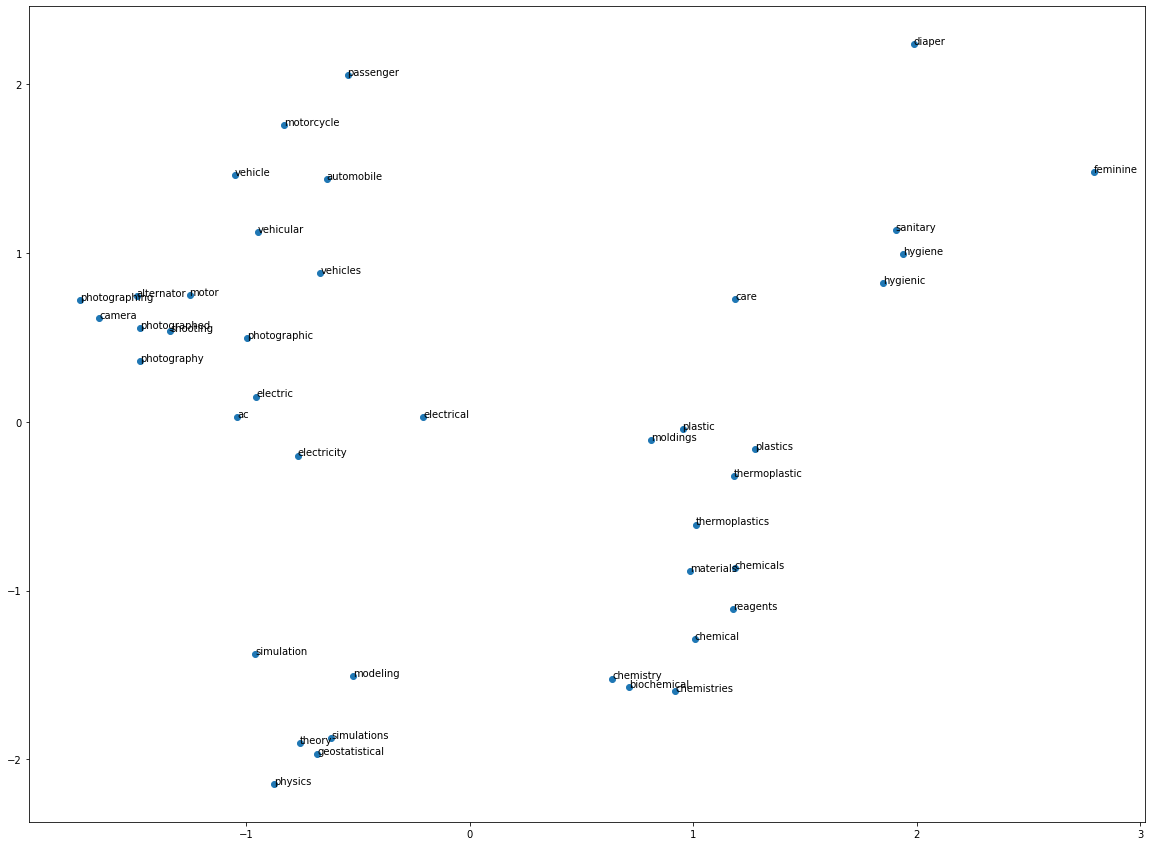

In [254]:
fig = plt.figure(1, figsize=(20, 15))
pca = PCA(n_components=2)
result = pca.fit_transform(sample_wv)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

### 2. t-SNE

In [229]:
from sklearn.manifold import TSNE
import numpy as np

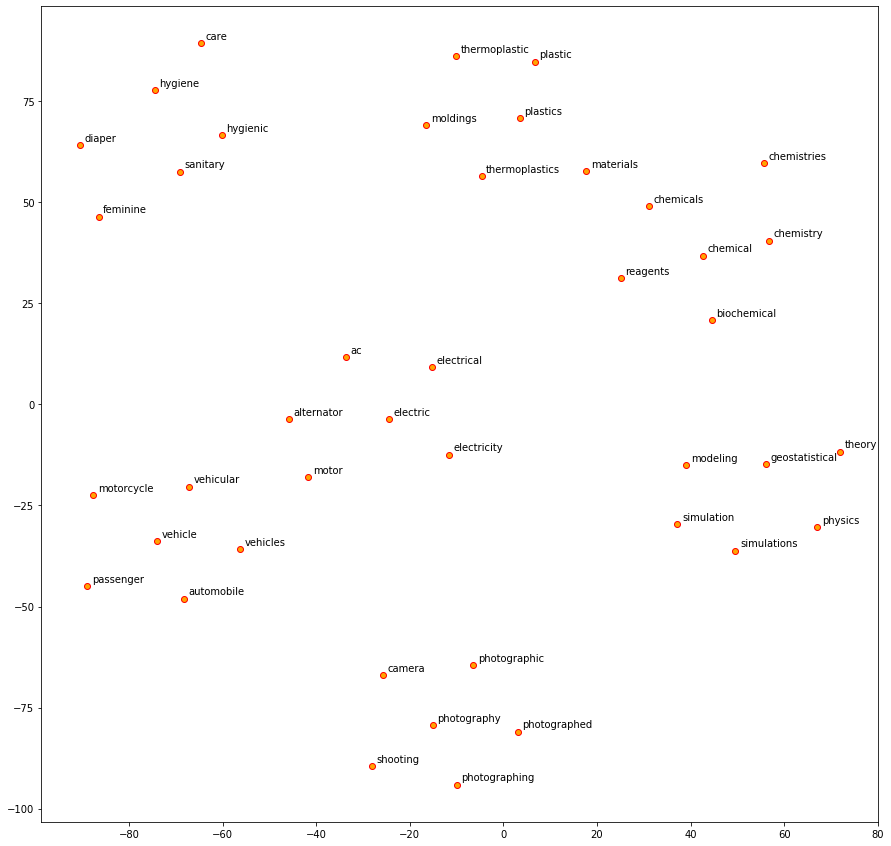

In [255]:
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=15)
np.set_printoptions(suppress=True)
result = tsne.fit_transform(sample_wv)
labels = words

plt.figure(figsize=(15, 15))
plt.scatter(result[:, 0], result[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, result[:, 0], result[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

Future work for phrases:
1) use doc2vec
2) average all word vectors in the phrases
3) create phrases during tokenization

In the experiment, the stopwords have not been removed, becaused it might remove the dependency information of the words from the sentences. 